# GLODAP global map

In [11]:
import numpy as np
from cmocean import cm
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater

In [12]:
df = pd.read_csv('/gpfs/home/mep22dku/scratch/SOZONE/evalOutput/datasets/GLODAPv2.2022_GLOBAL_valid_DICTA_umolL_STITCHED.csv')

In [21]:
tDIC = np.array(df['DIC'][:])
tALK = np.array(df['ALK'][:])


tSAL = np.array(df['SAL'][:])
tTEMP = np.array(df['TEMP'][:])
tPRES = np.array(df['PRES'][:])


# dens = seawater.dens(tSAL,tTEMP,tPRES)
# tDIC_umolkg = tDIC*1000/dens
# tALK_umolkg = tALK*1000/dens

tLAT = np.array(df['LAT'][:])
tLON = np.array(df['LON'][:])
tYEAR = np.array(df['YR'])
tMONTH = np.array(df['MONTH'])
tSTATION = np.array(df['STATION'])
tY = np.array(df['Y'])
tX = np.array(df['X'])
tZ = np.array(df['Zdep'])
tDP = np.array(df['DP'])
tREG = np.array(df['REG'])
tSEAS = np.zeros_like(tMONTH)
tSEAS[(tMONTH == 12) | (tMONTH <3)] = 1 #summer
tSEAS[(tMONTH >= 3) & (tMONTH <6)] = 2 #autumn
tSEAS[(tMONTH >= 6) & (tMONTH <9)] = 3 #winter
tSEAS[(tMONTH >= 9) & (tMONTH <12)] = 4

In [15]:
print(df.head(5))

   Unnamed: 0      YR  MONTH          DIC          ALK     SAL    TEMP   PRES  \
0           0  1972.0   10.0  2035.037339  2418.910077  36.056  26.660    9.0   
1           1  1972.0   10.0  2277.314363  2364.824183  34.638   6.894  521.0   
2           2  1972.0   10.0  2246.528517  2362.816984  34.662   7.582  446.0   
3           3  1972.0   10.0  2256.026578  2365.073007  34.754   8.321  376.0   
4           4  1972.0   10.0  2235.485978  2366.077845  34.872   9.481  297.0   

     LAT     LON     Y      X           Z  Zdep      DP  REG  STATION  CRUISE  
0 -0.987 -34.035  71.0  124.0    4.999938   0.0  8265.0  2.8     46.0   236.0  
1  3.945 -38.517  80.0  122.0  511.534765  19.0  8999.0  2.8     40.0   236.0  
2  3.945 -38.517  80.0  122.0  511.534765  19.0  8999.0  2.8     40.0   236.0  
3  3.945 -38.517  80.0  122.0  364.303040  18.0  8999.0  2.8     40.0   236.0  
4  3.945 -38.517  80.0  122.0  272.476722  17.0  8999.0  2.8     40.0   236.0  


In [16]:
print(len(np.unique(tSTATION)))

3188


# global plot

In [17]:
import cartopy.crs as ccrs
from cartopy import crs, feature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import matplotlib.ticker as mticker
import cartopy.crs as ccrs

from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

    # filters - TA and DIC, TEMP, SAL should exist, depth < 500, TA-DIC conditions, etc, filt_comp is a comprehensive filter of everything

In [25]:
#dic, ta, actual reasonable numbers
filt_ALK = ((tALK>-999) & (~np.isnan(tALK)))
filt_DIC = ((tDIC>-999) & (~np.isnan(tDIC)))
filt_SAL = (tSAL >-999) & (~np.isnan(tSAL))
filt_TEMP = (tTEMP >-999) & (~np.isnan(tTEMP))
filt_PRES = (tPRES >-999) & (~np.isnan(tPRES))
filt_EST = (filt_SAL) & (tSAL >= 20 ) & (tPRES < 201)
# filt_OXY = (tOXY > -999) & (~np.isnan(tOXY))
# filt_AOU = (tAOU>-999) & (~np.isnan(tAOU))
filt_YEAR = (tYEAR > 1990)

# #bottom depth relatively shallow <
# filt_DEPTH = (tBOTdepth < 1001) & filt_ALK & filt_DIC & filt_SAL
# #year is modern
# filt_DEPTH2 = (tBOTdepth < 501) & filt_ALK & filt_DIC & filt_SAL

# filt_comp = filt_DEPTH2& filt_EST & filt_PRES & filt_SAL & filt_TEMP & filt_DIC & filt_ALK

filt_comp =  filt_EST & filt_PRES & filt_SAL & \
filt_TEMP & filt_DIC & filt_ALK  & filt_YEAR #& filt_DEPTH2 & filt_AOU



#? why tDIC+50

In [26]:

tALK_DIC = tALK-tDIC
tALK_DIC2 = tALK-(tDIC+50)
filt_ALK_DIC = (np.abs(tALK_DIC) < 50) & (filt_ALK) & (filt_DIC) & (filt_SAL)
filt_ALK_DIC2 = (np.abs(tALK_DIC2) < 50) & (filt_ALK) & (filt_DIC) & (filt_SAL)

In [27]:
###### manually assign geolocations
#? ? to alternative 'tBotdepth' -- 'tZ'
#tGEO = np.zeros_like(tBOTdepth)

tGEO = np.zeros_like(tZ)

#canadian arctic
westlon = -148; eastlon = -50; southlat = 60; northlat = 85
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 1

#euro arctic
westlon = -30; eastlon = 91; southlat = 70; northlat = 85
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 2
#atlantic 1
westlon = -50; eastlon = 30; southlat = 0; northlat = 70
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 3
#atlantic 2
westlon = -100; eastlon = -50; southlat = 0; northlat = 60
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 3
#siberian arctic
westlon = 91; eastlon = 180; southlat = 68; northlat = 91
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 4
#pacific coast
westlon = -140; eastlon = -100; southlat = 10; northlat = 60
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 5
#Russian-Alaskan Interface
westlon = -180; eastlon = -148; southlat = 50; northlat = 90
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 6
#Kamchatka Region
westlon = 120; eastlon = 180; southlat = 48; northlat = 68
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 7
#Japan and China
westlon = 120; eastlon = 180; southlat = 10; northlat = 48
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 8
#SO
westlon = -180; eastlon = 180; southlat = -90; northlat = -60
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 9

In [24]:
PLACES_withdat = {
'Canadian Arctic': { 'geodat': 1, 'colour': 'blueviolet', 'name':'Canadian Arctic'},
'European Arctic': { 'geodat': 2, 'colour': 'darkorange', 'name':'European Arctic'},
'N. Atlantic': { 'geodat': 3, 'colour': 'red', 'name':'N. Atlantic'},
'Siberian Arctic': { 'geodat': 4, 'colour': 'dodgerblue', 'name':'Siberian Arctic'},
'Coastal Pacific': { 'geodat': 5, 'colour': 'blue', 'name':'Coastal Pacific'},
'Russian/Alaskan Interface': { 'geodat': 6, 'colour': 'skyblue', 'name':'Russian/Alaskan \n Interface'},
'Kamchatka Region': { 'geodat': 7, 'colour': 'lightsteelblue', 'name':'Kamchatka Region'},
'China/Japan': { 'geodat': 8, 'colour': 'steelblue', 'name':'China/Japan'},
'Southern Ocean': { 'geodat': 9, 'colour': 'green', 'name':'Southern Ocean'},
'Everything Else': { 'geodat': 0, 'colour': 'grey', 'name':'Everything Else'},
}

list_places = ['Everything Else','Canadian Arctic','European Arctic',
'N. Atlantic','Siberian Arctic','Coastal Pacific',
'Russian/Alaskan Interface',
'Kamchatka Region','China/Japan',
'Southern Ocean',]

print(list_places)

['Everything Else', 'Canadian Arctic', 'European Arctic', 'N. Atlantic', 'Siberian Arctic', 'Coastal Pacific', 'Russian/Alaskan Interface', 'Kamchatka Region', 'China/Japan', 'Southern Ocean']


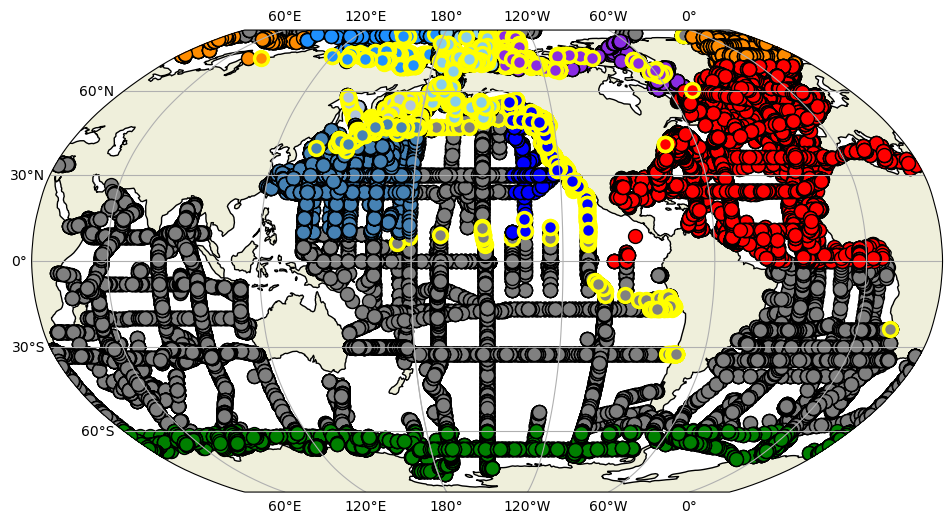

In [28]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=-150.0), )
ms = 20
# make the map global rather than have it zoom in to
# the extents of any plotted data
ax.set_global()
ax.coastlines(facecolor = 'k')
# ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor='darkgray'))
ax.add_feature(feature.LAND)

for i in range(0,len(list_places)):
    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])
    #print('(╯°□°）╯︵ ┻━┻')
    #print(tLON[filt_comp & (tGEO == geotag)])
    ax.plot(tLON[filt_comp & (tGEO == geotag)],\
            tLAT[filt_comp & (tGEO == geotag)],\
           color = tcol, marker = '.', markeredgecolor = 'k', markeredgewidth = 1,\
            markersize = ms, linestyle = '',\
           label = tnam, alpha = 1, transform=ccrs.PlateCarree())
    
    ax.plot(tLON[filt_comp & filt_ALK_DIC & (tGEO == geotag)],\
            tLAT[filt_comp &  filt_ALK_DIC & (tGEO == geotag)],\
           color = tcol, marker = '.', markersize = ms, linestyle = '',\
            markeredgecolor = 'yellow', markeredgewidth = 2.5,
           label = tnam, alpha = 1, transform=ccrs.PlateCarree())
    
# gl = ax.gridlines(draw_labels=False, xlocs=np.arange(-180, 181, 60), ylocs=np.arange(-90, 91, 15))
# gl.rotate_labels = False
# gl.top_labels = False
# gl.bottom_labels = False

gl = ax.gridlines(draw_labels=True)
gl.rotate_labels = False
# gl.top_labels = False
gl.left_labels = gl.bottom_labels = True
#gl.right_labels = gl.top_labels = False

# gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='black', alpha=0.5, linestyle='--', draw_labels=True)
# gl.xlabels_top = False
# gl.ylabels_left = False
# gl.ylabels_right=True
# gl.xlines = True
# gl.xlocator = mticker.FixedLocator([120, 140, 160, 180, -160, -140, -120])
# gl.ylocator = mticker.FixedLocator([0, 20, 40, 60])
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER
# gl.xlabel_style = {'color': 'black', 'weight': 'normal'}

# plt.title(r'$\bf{a)}$ Available coastal GLODAP DIC and TA measurements')
# plt.show()
# fig.savefig('./CG_FIGS/FIG_CG_08_map.jpg')